In [1]:
# a script for making pretty plots

In [154]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import csv as csv

from sklearn import linear_model, datasets

%matplotlib inline

In [ ]:
def make_graphs(idx, image):
    # image = 'N2_dpy-23_ex_int_ama-1_015'
    path = '/Users/kkolyva/milky-graphs/data/' + image + '/c3/'
    # file = 'N2_dpy-23_ex_int_ama-1_015.nd2 - N2_dpy-23_ex_int_ama-1_015.nd2 (series ' + str(idx).zfill(2) + ').tif.csv'
    file = image + '.nd2 - ' + image + '.nd2 (series ' + str(idx).zfill(2) + ').tif.csv'
    
    data = np.loadtxt(path + file, delimiter = '\t')
    z = data[:, 3]
    I = data[:, 4]
    
    return (z, I)

In [350]:
# returns the y coordinate for the given line
# y = kx + b; also works with vectors
def f_x(x_, k_, b_):
    return k_*x_ + b_

In [351]:
def ransac_fit(I, z):
    # Robustly fit linear model with RANSAC algorithm
    ransac = linear_model.RANSACRegressor()
    ransac.fit(z.reshape(-1,1), I)
    # inlier_mask = ransac.inlier_mask_
    
    # Predict data of estimated models
    line_X = np.arange(z.reshape(-1,1).min(), z.reshape(-1,1).max())[:, np.newaxis]
    line_y_ransac = ransac.predict(line_X)
    
    # The slope of the line
    # print(ransac.estimator_.coef_[0], ransac.estimator_.intercept_)
    lines_params[idx - 1, :] = [ransac.estimator_.coef_[0], ransac.estimator_.intercept_]
    
    # fixing the slope here
    # return k, b; last 2 are for the visualizations
    return (lines_params[idx - 1, 0], lines_params[idx - 1, 1], line_X, line_y_ransac)

In [352]:
def linear_fit(I, z):
    # Robustly fit linear model with RANSAC algorithm
    lr = linear_model.LinearRegression()
    lr.fit(z.reshape(-1,1), I)
    
    # Predict data of estimated models
    line_X = np.arange(z.reshape(-1,1).min(), z.reshape(-1,1).max())[:, np.newaxis]
    line_y_lr = lr.predict(line_X)
    
    # The slope of the line
    # print(ransac.estimator_.coef_[0], ransac.estimator_.intercept_)
    lines_params[idx - 1, :] = [lr.coef_[0], lr.intercept_]
    
    # fixing the slope here
    # return k, b; last 2 are for the visualizations
    return (lines_params[idx - 1, 0], lines_params[idx - 1, 1], line_X, line_y_lr)

In [353]:
# returns the adjusted intensity values
def perform_correction(I, z, k, b):
    z_min_arg = z.argmin()

    dI = f_x(z.min(), k, b) - f_x(z, k, b)  
    I_adj = I + dI 
    
    return (I_adj)

In [358]:
# generl setup for pretty images 
num_files = 11
lines_params = np.zeros([num_files, 2])
image = 'N2_dpy-23_ex_int_ama-1_015'
Ia_min, Ia_max = 10000, 55000
za_min, za_max = 0, 55

In [360]:
def plot_fitting(I, I_adj, z, idx, line_X, line_y):
    plt.subplot(num_files, 2, 2*idx - 1);
    plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif')
    plt.xlabel('z')
    plt.ylabel('I_0')
    plt.grid(which='major', axis='both', linestyle='dashed')
    plt.axis([za_min, za_max, Ia_min, Ia_max])

    plt.plot(z, I, 'ro', label='mRNA')
    # plt.plot(z.reshape(-1,1)[inlier_mask], I[inlier_mask],  'go')
    
    plt.plot(line_X, line_y, color='cornflowerblue', linewidth=4, label='Fit')
    plt.legend(loc='upper right')
    
    plt.subplot(num_files, 2, 2*idx);
    plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif')
    plt.xlabel('z')
    plt.ylabel('I_0_fixed')
    plt.grid(which='major', axis='both', linestyle='dashed')
    plt.axis([za_min, za_max, Ia_min, Ia_max])

    plt.plot(z, I_adj, 'ro', label='mRNA')
    
    plt.legend(loc='upper right')

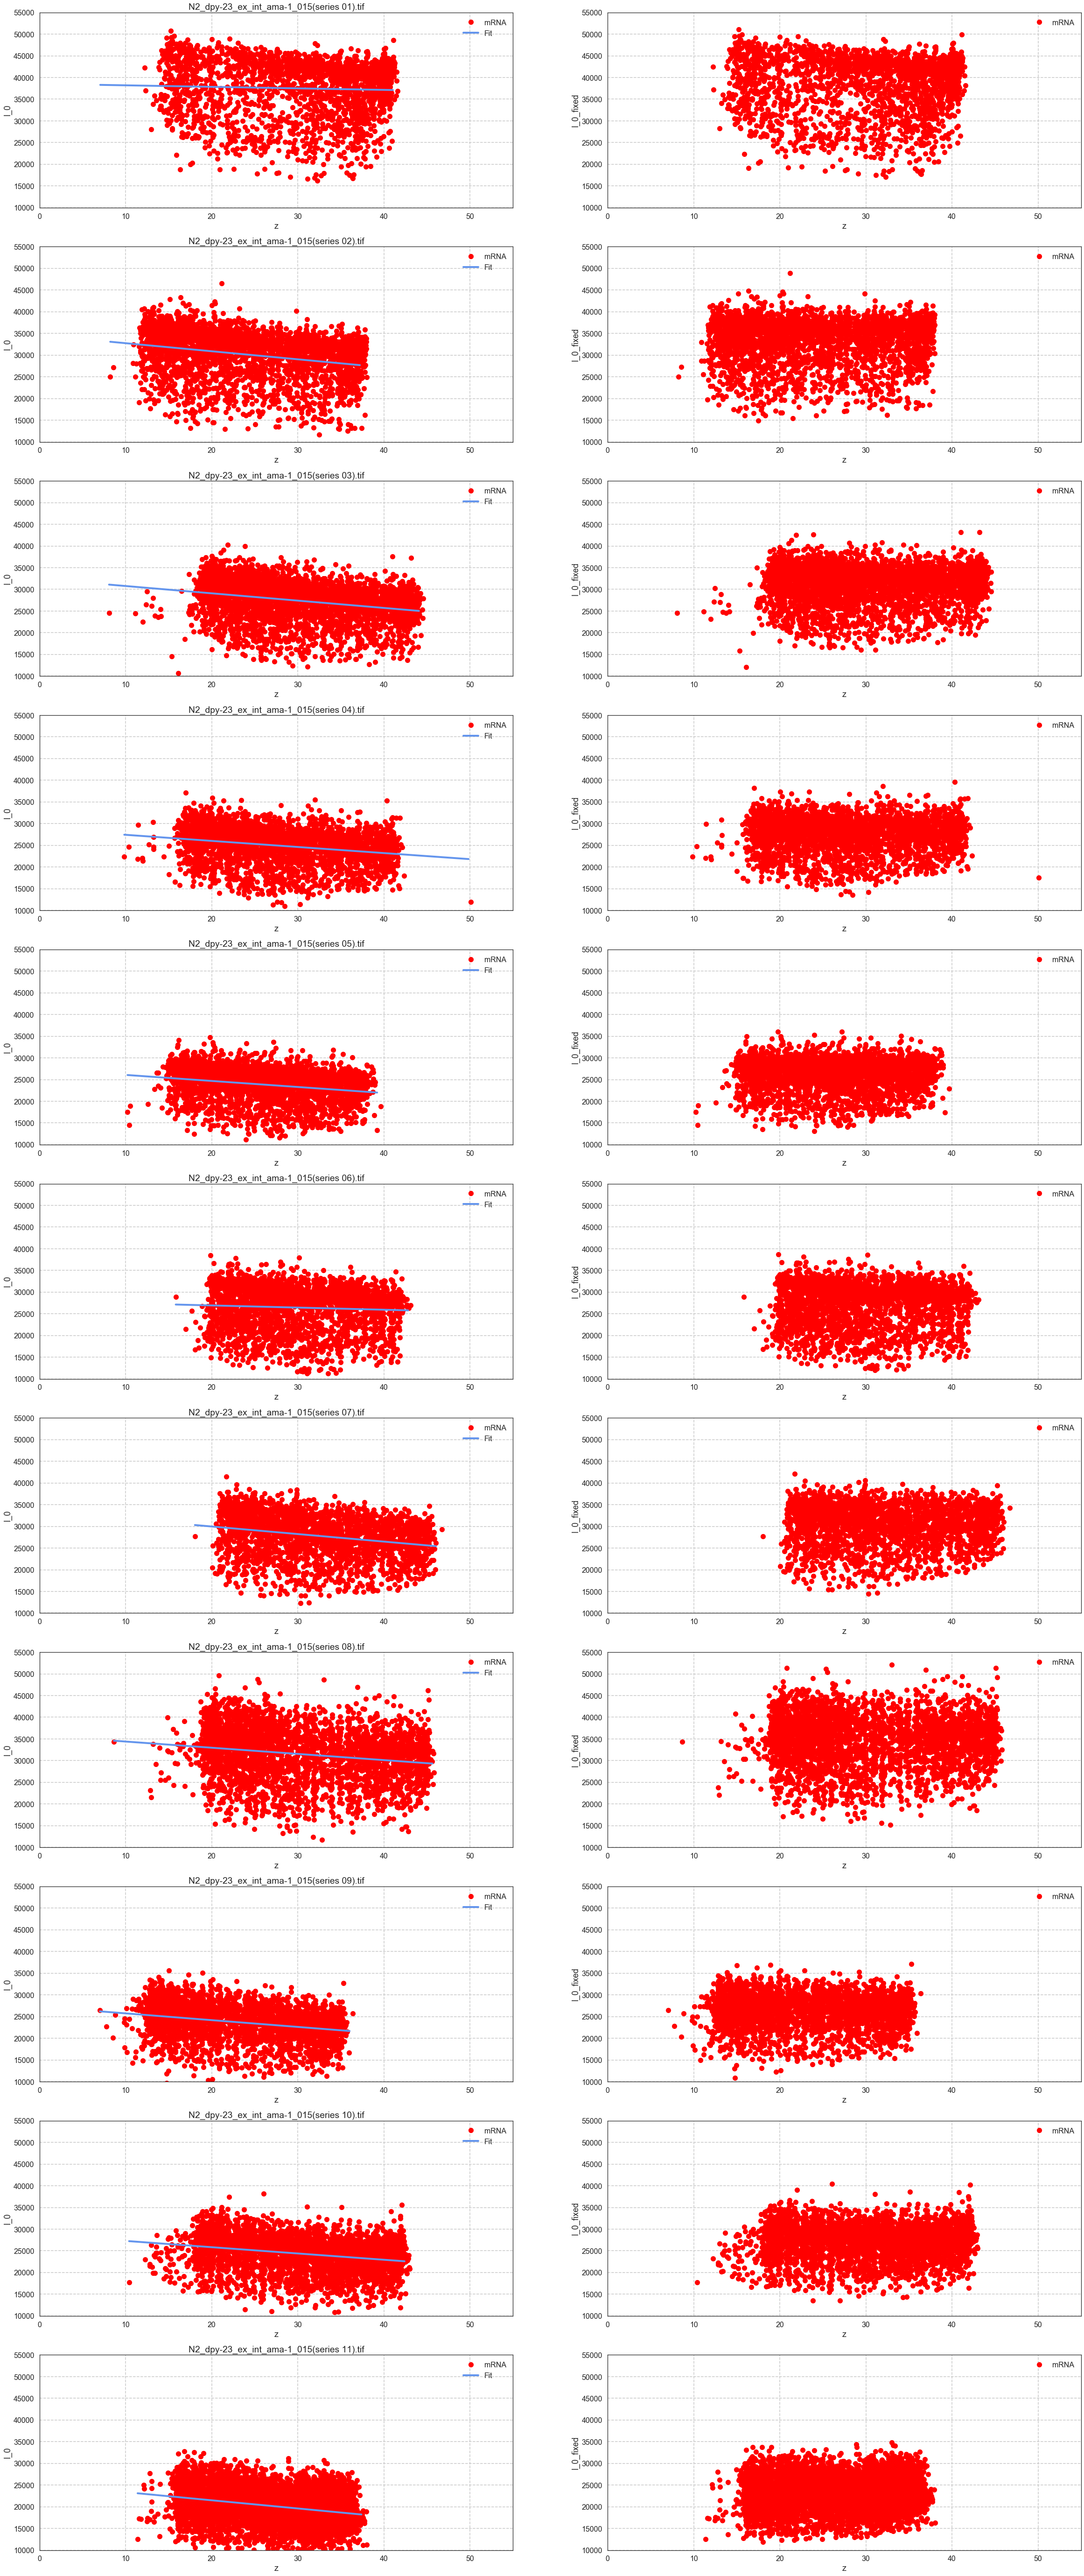

In [361]:
plt.figure(figsize=(40,100))
for idx in range (1, num_files + 1):
    z, I = make_graphs(idx, image)   
    
    k, b, line_X, line_y = linear_fit(I, z)
    I_adj = perform_correction(I, z, k, b) 
 
    plot_fitting(I, I_adj, z, idx, line_X, line_y)
# plt.savefig('sample.pdf')

In [362]:
def plot_distribution(I, I_adj): 
    plt.subplot(num_files, 2, 2*idx - 1);
    plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif')
    plt.xlabel('I_0')
    plt.ylabel('# of mRNAs')
    plt.axis([10000, 55000, 0, 100])
    plt.grid(which='major', axis='both', linestyle='dashed')
    plt.hist(I, bins=np.arange(min(I), max(I) + binwidth, binwidth), color=['pink'])[2]
    
    plt.subplot(num_files, 2, 2*idx);
    plt.title(image + ' (series ' + str(idx).zfill(2) + ').tif')
    plt.xlabel('I_0_adj')
    plt.ylabel('# of mRNAs')
    plt.axis([10000, 55000, 0, 100])
    plt.grid(which='major', axis='both', linestyle='dashed')
    plt.hist(I_adj, bins=np.arange(min(I), max(I) + binwidth, binwidth), color=['pink'])[2]

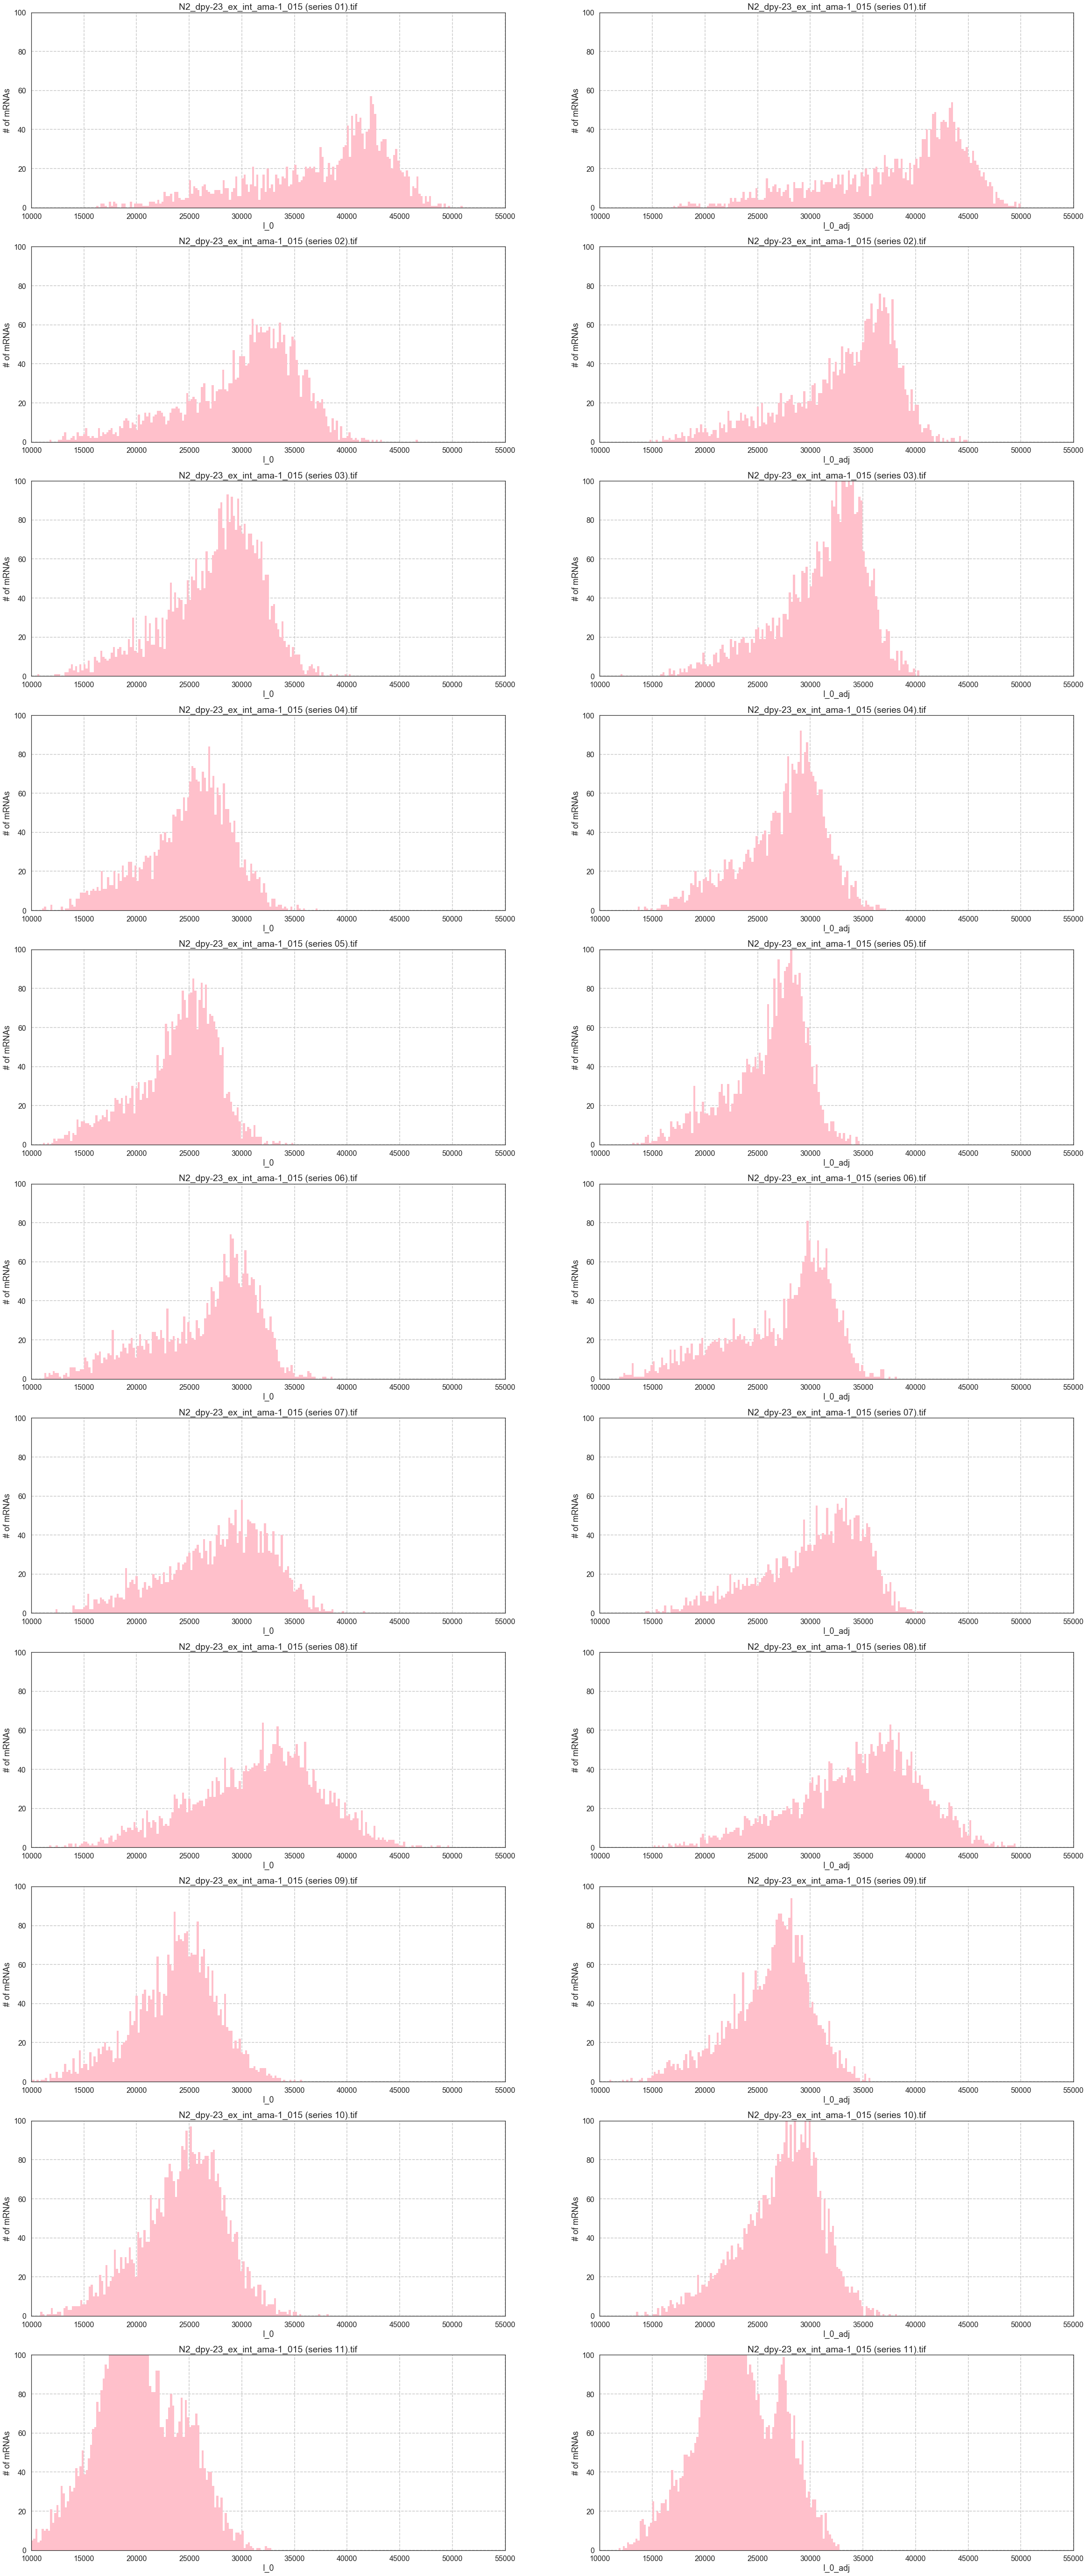

In [365]:
binwidth = 200
plt.figure(figsize=(40,100))
for idx in range (1, num_files + 1):
    z, I = make_graphs(idx, image)   
    
    k, b, line_X, line_y = linear_fit(I, z)
    I_adj = perform_correction(I, z, k, b) 
    
    plot_distribution(I, I_adj)
# plt.savefig('sample.pdf')